# Лабораторная работа №1.2 по Цифровой Обработке Изображений на тему "Распознавание объектов по цвету"

- [Задачи](#Задачи:)
- [Набор данных](#Набор-данных)
- [Гистограммы и как с ними работать](#Гистограммы-и-как-с-ними-работать)
    - [Одноканальные гистограммы](#Одноканальные-гистограммы)
    - [Двухканальные гистограммы](#Двухканальные-гистограммы)
    - [Трёхканальная гистограмма](#Трёхканальная-гистограмма)
- [Подбор параметров функции HoughCircles](#Подбор-параметров-функции-HoughCircles)
- [Основная программа](#Основная-программа)

## Задачи:
1. Подготовить выборку 10 (или более)цветных цифровых изображений блюд (по аналогии с примером внизу).
2. На языке Python (3.х) создать проект и подключить библиотеку scikit-image.
3. Из Lab1.2 взять модуль загрузки цветного цифрового изображения и модуль обработки пикселей.
4. Запрограммировать формулу перевода цветного цифрового изображения в цветовое пространство в соответствии с вариантом (В1: RGB; В2: HSV; В3: CMYK; В4: YUV; В5: Hough Circle+HSV; В6: Hough Circle +HSL).
5. Создать классификацию блюд из цифровых изображений.
6. Для каждого блюда определить цветовые характеристики. Задать распределение значений каждого цвета.
7. Провести эксперимент по распознаванию блюд с визуализацией результатов.
8. Дать комментарий каждой строчке кода!
9. Прислать программу преподавателю.
10. Построить график ошибок первого и второго рода по результатам распознавания.
11. Подготовить и прислать отчет (титульный лист, задание, теоретическая часть, диаграмма структуры программы, принтскрины интерфейса и основных шагов работы программы, заключение и выводы, листинг программы с комментариями, список использованной литературы).

## Набор данных
Я подготовил наборы данных для обучения и тестирования. Набор обучающих данных состоит из изображений, разделённых на 6 частей в зависимости от блюда: картофель, помидор, яйца, мандарин, виноград и банан. Каждая часть состоит из 9-10 изображений. Каждое изображение в наборе обучающих данных содержит только одну тарелку с блюдом. Набор данных для тестирования содержит 19 изображений. Каждое изображение в нём содержит 3 тарелки с разными блюдами.

In [1]:
import os
import cv2
from matplotlib import pyplot as plt
from matplotlib import patches
import numpy as np
%matplotlib inline


TRAIN_PATH = os.path.join(os.getcwd(), 'dataset/train')
TEST_PATH = os.path.join(os.getcwd(), 'dataset/test')
CHANNEL1 = 0
CHANNEL2 = 1
CHANNEL3 = 2
H_MAX = 180
L_MAX = 256
S_MAX = 256
MASK = None
H_RANGE = [0, H_MAX]
L_RANGE = [0, L_MAX]
S_RANGE = [0, S_MAX]
# Fine tunning by hands!
TRAIN_SETTINGS = dict(dp=2, minDist=350, param1=650, param2=100, minRadius=175, maxRadius=225)
# Fine tunning by hands!
TEST_SETTINGS = dict(dp=2, minDist=300, param1=500, param2=100, minRadius=130, maxRadius=140)
GREEN_COLOR = (0, 1.0, 0)
WHITE_COLOR = (1.0, 1.0, 1.0)

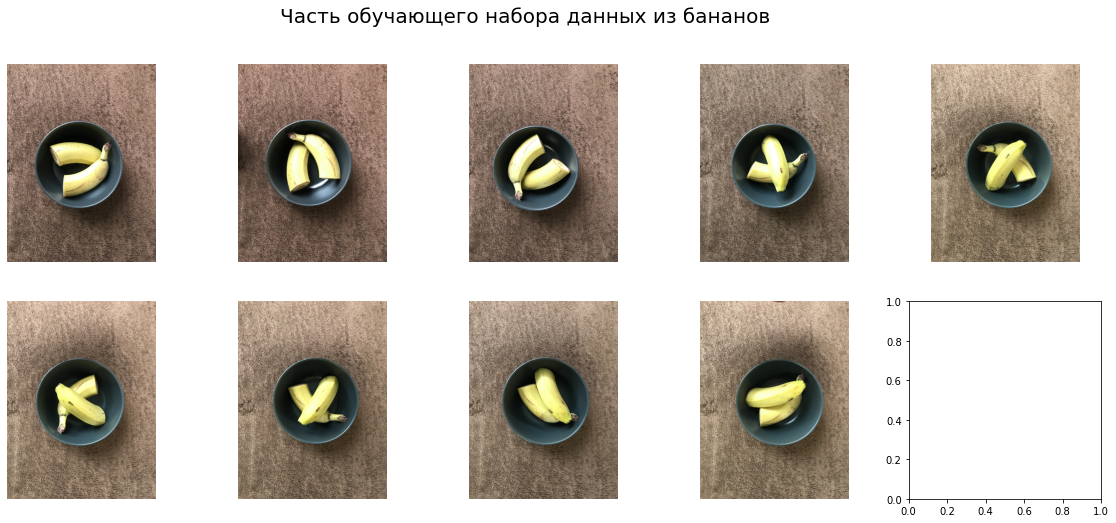

In [2]:
labels = os.listdir(TRAIN_PATH)
label_path = os.path.join(TRAIN_PATH, labels[0])
file_names = os.listdir(label_path)
images = []
for file_name in file_names:
    file_path = os.path.join(label_path, file_name)
    image = plt.imread(file_path)
    images.append(image)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for ax, image in zip(axes, images):
    ax.imshow(image)
    ax.set_axis_off()
fig.suptitle('Часть обучающего набора данных из бананов', fontsize=20)
plt.show()

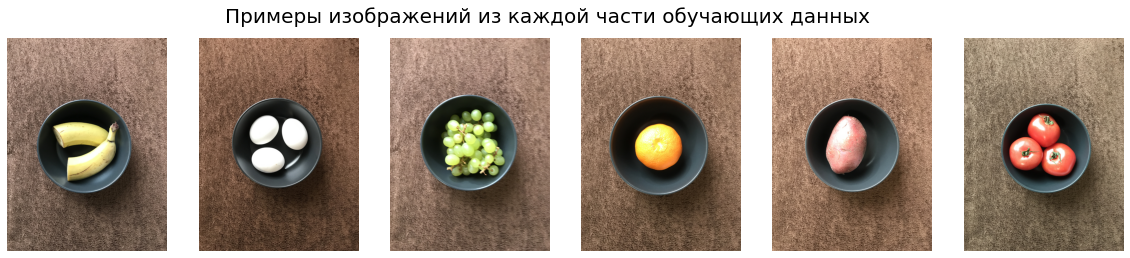

In [3]:
images = []
for label in labels:
    label_path = os.path.join(TRAIN_PATH, label)
    file_names = os.listdir(label_path)
    file_path = os.path.join(label_path, file_names[0])
    image = plt.imread(file_path)
    images.append(image)

fig, axes = plt.subplots(1, 6, figsize=(20, 4))
axes = axes.flatten()
for ax, image in zip(axes, images):
    ax.imshow(image)
    ax.set_axis_off()
fig.suptitle('Примеры изображений из каждой части обучающих данных', fontsize=20)
plt.show()

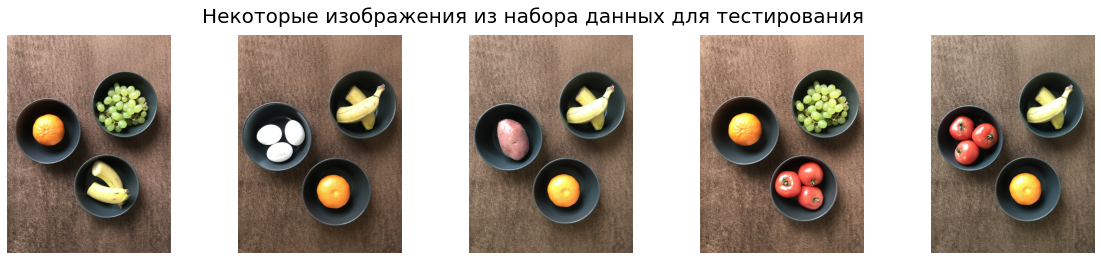

In [4]:
images = []
file_names = os.listdir(TEST_PATH)
for file_name in file_names:
    file_path = os.path.join(TEST_PATH, file_name)
    image = plt.imread(file_path)
    images.append(image)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axes = axes.flatten()
for ax, image in zip(axes, images):
    ax.imshow(image)
    ax.set_axis_off()
fig.suptitle('Некоторые изображения из набора данных для тестирования', fontsize=20)
plt.show()

## Гистограммы и как с ними работать

In [5]:
image = cv2.imread(os.path.join(TRAIN_PATH, 'banana', 'banana1.png'))
hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
h, l, s = cv2.split(hls_image)

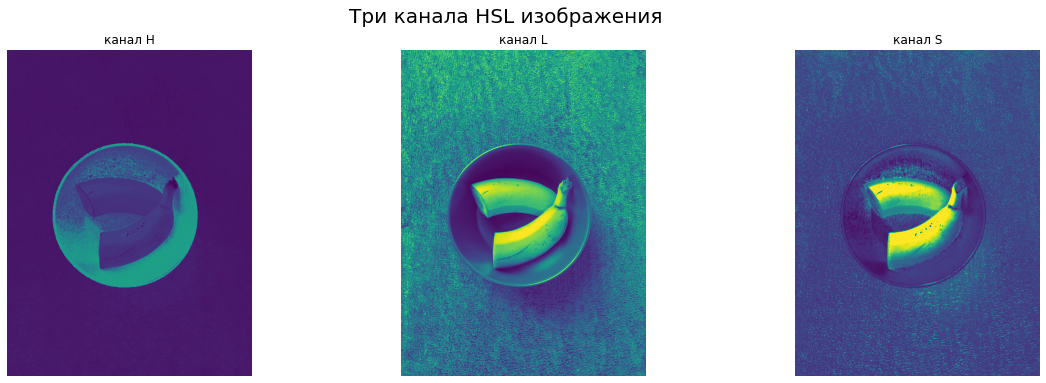

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].imshow(h)
axes[0].set_title('канал H')
axes[0].set_axis_off()
axes[1].imshow(l)
axes[1].set_title('канал L')
axes[1].set_axis_off()
axes[2].imshow(s)
axes[2].set_title('канал S')
axes[2].set_axis_off()
fig.suptitle('Три канала HSL изображения', fontsize=20)
plt.show()

### Одноканальные гистограммы

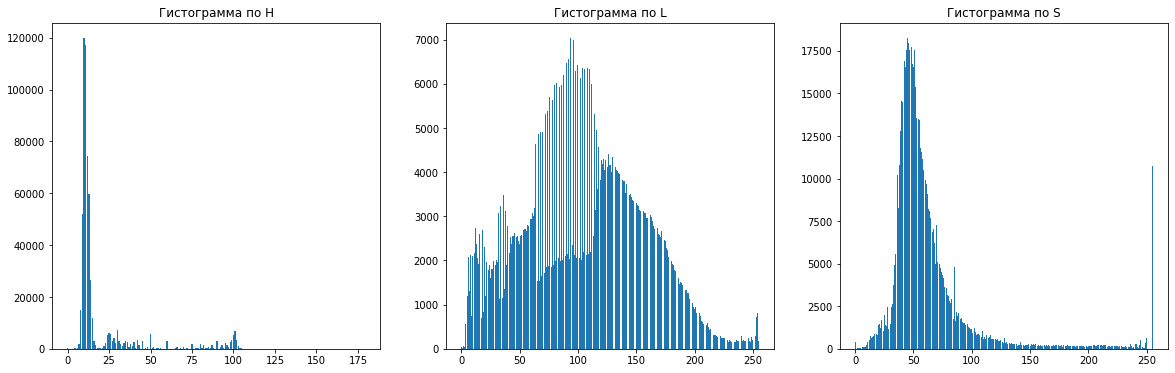

In [7]:
# calcHist: https://docs.opencv.org/4.5.1/d6/dc7/group__imgproc__hist.html#ga4b2b5fd75503ff9e6844cc4dcdaed35d
h_hist = cv2.calcHist([h], [CHANNEL1], MASK, [H_MAX], H_RANGE, accumulate=False)
h_hist = h_hist.flatten()
l_hist = cv2.calcHist([l], [CHANNEL1], MASK, [L_MAX], L_RANGE, accumulate=False)
l_hist = l_hist.flatten()
s_hist = cv2.calcHist([s], [CHANNEL1], MASK, [S_MAX], S_RANGE, accumulate=False)
s_hist = s_hist.flatten()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].bar(range(H_MAX), h_hist)
axes[0].set_title('Гистограмма по H')

axes[1].bar(range(L_MAX), l_hist)
axes[1].set_title('Гистограмма по L')

axes[2].bar(range(S_MAX), s_hist)
axes[2].set_title('Гистограмма по S')

plt.show()

### Двухканальные гистограммы

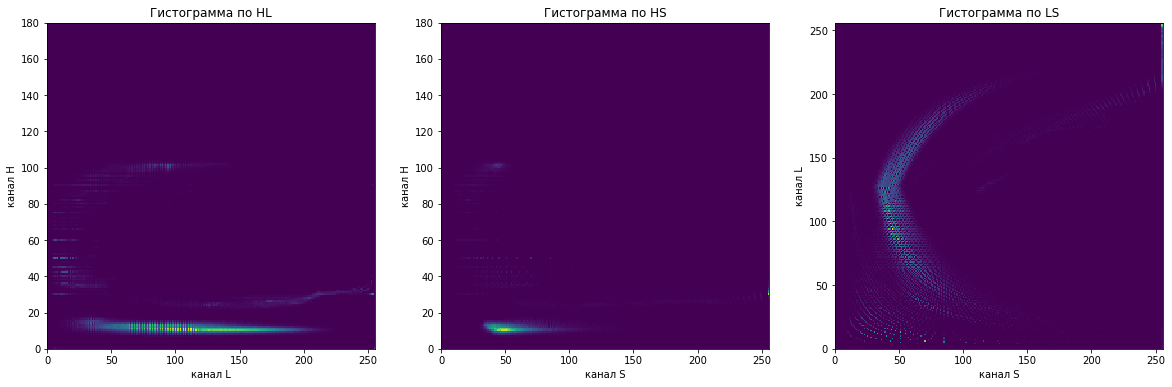

In [8]:
hist2D_HL = cv2.calcHist([hls_image], [CHANNEL1, CHANNEL2], MASK, [H_MAX, L_MAX], H_RANGE + L_RANGE, accumulate=False)
hist2D_HS = cv2.calcHist([hls_image], [CHANNEL1, CHANNEL3], MASK, [H_MAX, S_MAX], H_RANGE + S_RANGE, accumulate=False)
hist2D_LS = cv2.calcHist([hls_image], [CHANNEL2, CHANNEL3], MASK, [L_MAX, S_MAX], L_RANGE + S_RANGE, accumulate=False)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].pcolor(hist2D_HL)
axes[0].set_title('Гистограмма по HL')
axes[0].set_xlabel('канал L')
axes[0].set_ylabel('канал H')

axes[1].pcolor(hist2D_HS)
axes[1].set_title('Гистограмма по HS')
axes[1].set_xlabel('канал S')
axes[1].set_ylabel('канал H')

axes[2].pcolor(hist2D_LS)
axes[2].set_title('Гистограмма по LS')
axes[2].set_xlabel('канал S')
axes[2].set_ylabel('канал L')
plt.show()

### Трёхканальная гистограмма
представляет собой параллепипед из вокселей. Поэтому она не может изображена.

In [9]:
hist3D = cv2.calcHist(
    [hls_image],
    [CHANNEL1, CHANNEL2, CHANNEL3],
    MASK,
    [H_MAX, L_MAX, S_MAX],
    H_RANGE + L_RANGE + S_RANGE,
    accumulate=False
)

## Подбор параметров функции HoughCircles

В иделае она должна находить все тарелки на изображении.

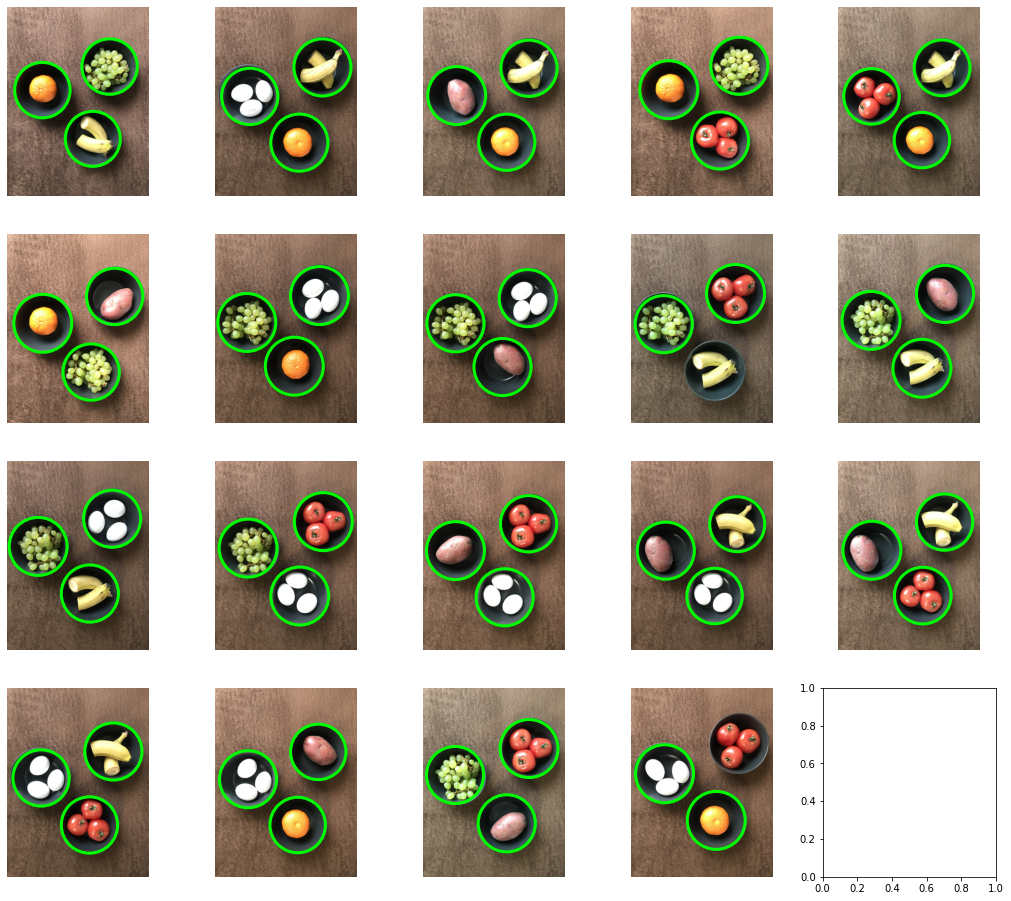

In [10]:
def circles_check(path):
    """
    Used to set up arguments in a function cv2.HoughCircles.

    path - to the directory with images.
    """
    filenames = os.listdir(path)
    _, axes = plt.subplots(4, 5, figsize=(18, 16))
    axes = axes.flatten()
    for ax, filename in zip(axes, filenames):
        image = plt.imread(os.path.join(path, filename))
        grayscale_image = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)
        # Fine tunning by hands!
        circles = cv2.HoughCircles(
            grayscale_image,
            cv2.HOUGH_GRADIENT,
            dp=2,
            minDist=300,
            param1=500,
            param2=100,
            minRadius=130,
            maxRadius=140
        )
        if circles is not None:
            for circle in circles[0]:
                x, y, r = map(int, circle)
                draw_circle = patches.Circle((x, y), radius=r, color=GREEN_COLOR, linewidth=3, fill=False)
                ax.set_axis_off()
                ax.imshow(image)
                ax.add_patch(draw_circle)
        else:
            print('No circles found.')

    plt.show()


circles_check(TEST_PATH)

## Основная программа

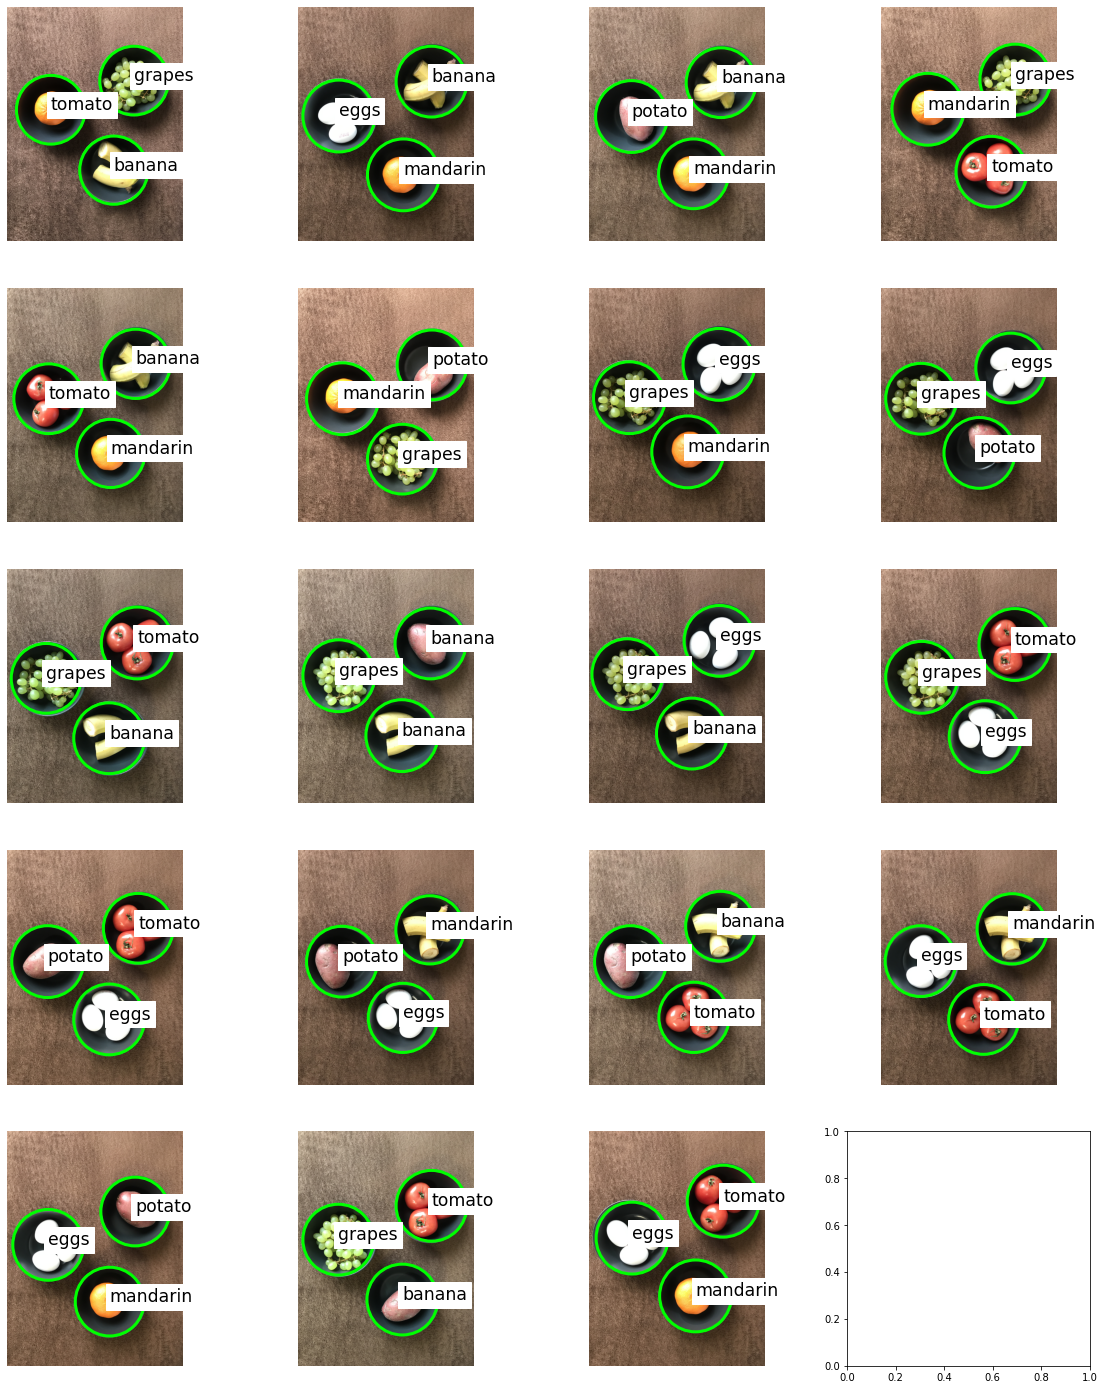

In [11]:
def get_circles(image, settings):
    """
    Returns a list of the circles found in the image.
    
    image - the image on which the circles are searched.
    settings - a named argument dictionary for the HoughCircles function.
    HoughCircles: https://docs.opencv.org/4.5.1/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d
    """
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(grayscale_image, cv2.HOUGH_GRADIENT, **settings)
    return circles[0]


def get_intermediate_accumulator(image):
    """Returns the accumulator histogram for the cropped parts of the image with circles."""
    intermediate_accumulator = np.zeros((H_MAX, L_MAX, S_MAX))
    circles = get_circles(image, TRAIN_SETTINGS)
    hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    for circle in circles:
        x, y, r = map(int, circle)
        crop = hls_image[y-r:y+r, x-r:x+r, :]
        hist = cv2.calcHist(
            [crop],
            [CHANNEL1, CHANNEL2, CHANNEL3],
            MASK,
            [H_MAX, L_MAX, S_MAX],
            H_RANGE + L_RANGE + S_RANGE,
            accumulate=False
        )
        intermediate_accumulator += hist
    return intermediate_accumulator


def get_mean_hist(path, label):
    """Returns the mean histogram for the label."""
    filenames = os.listdir(os.path.join(path, label))
    accumulator = np.zeros((H_MAX, L_MAX, S_MAX))
    for filename in filenames:
        image = cv2.imread(os.path.join(path, label, filename))
        intermediate_accumulator = get_intermediate_accumulator(image)
        accumulator += intermediate_accumulator
    mean_hist = accumulator / len(filenames)
    mean_hist = mean_hist.astype('float32')
    return mean_hist


def train(path):
    """
    Returns a dictionary where the key=label, value=mean histogram.
    
    path - path to train dataset.
    """
    labels = os.listdir(path)
    some_dict = {}
    for label in labels:
        some_dict[label] = get_mean_hist(path, label)
    return some_dict


def get_predict(hist, train_results):
    """
    Returns predicted label for input hisogram.
    
    train_results - dictionary where the key=label, value=mean histogram.
    """
    some_dict = train_results.copy()
    predict = None
    for label, label_hist in some_dict.items():
        compare = cv2.compareHist(hist, label_hist, cv2.HISTCMP_CORREL)
        some_dict[label] = compare
    max_compare = None
    for label, compare in some_dict.items():
        if max_compare is None or compare > max_compare:
            max_compare = compare
            predict = label
    return predict


def test(path, train_results):
    """
    Shows test images with found circles and predicted labels for them.
    
    path - path to test dataset.
    train_results - dictionary where the key=label, value=mean histogram.
    """
    fig, axes = plt.subplots(5, 4, figsize=(20, 25))
    axes = axes.flatten()
    filenames = os.listdir(path)
    for ax, filename in zip(axes, filenames):
        bgr_image = cv2.imread(os.path.join(path, filename))
        rgb_image = plt.imread(os.path.join(path, filename))
        circles = get_circles(bgr_image, TEST_SETTINGS)
        hls_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HLS)
        for circle in circles:
            x, y, r = map(int, circle)
            crop = hls_image[y-r:y+r, x-r:x+r, :]
            hist = cv2.calcHist(
                [crop],
                [CHANNEL1, CHANNEL2, CHANNEL3],
                MASK,
                [H_MAX, L_MAX, S_MAX],
                H_RANGE + L_RANGE + S_RANGE,
                accumulate=False
            )
            predict = get_predict(hist, train_results)
            
            draw_circle = patches.Circle(
                (x, y),
                radius=r,
                color=GREEN_COLOR,
                linewidth=3,
                fill=False
            )
            ax.imshow(rgb_image)
            ax.set_axis_off()
            ax.add_patch(draw_circle)
            ax.text(x, y, predict, fontsize='xx-large', backgroundcolor=WHITE_COLOR)
    plt.show()


train_results = train(TRAIN_PATH)
test(TEST_PATH, train_results)

По результатам тестирования построили следующую матрицу ошибок:

|          | grapes | mandarin | banana | eggs | potato | tomato |
|----------|:------:|:--------:|:------:|:----:|:------:|:------:|
| grapes   |   11   |          |        |      |        |        |
| mandarin |        |     8    |    2   |      |        |        |
| banana   |        |          |    8   |      |        |        |
| eggs     |        |          |        |  9   |   2    |        |
| potato   |        |          |        |      |   7    |        |
| tomato   |        |     1    |        |      |        |   9    |